### Importing core libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import seaborn as sns
import datetime

### Importing dataset

In [2]:
df = pd.read_excel('../DB/Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Transforming dataset

In [12]:
df['TotalSum'] = df.Quantity * df.UnitPrice
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
#Creacion de fechas
snapshot_date = max(df.InvoiceDate) + datetime.timedelta(days=1)

# Aggregate data on a customer level
datamart = df.groupby(['CustomerID']).agg({
'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
'InvoiceNo': 'count',
'TotalSum': 'sum'})

# Rename columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency',
'InvoiceNo': 'Frequency',
'TotalSum': 'Monetary'}, inplace=True)

# Check the first rows
datamart.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [14]:
# Aggregate data on a customer level
datamart2 = df.groupby(['CustomerID']).agg({
'InvoiceDate': lambda x: (snapshot_date - x.min()).days})

# Rename columns for easier interpretation
datamart2.rename(columns = {'InvoiceDate': 'Tenure'}, inplace=True)

datamart2.head()

,Tenure
CustomerID,
12346.0,326
12347.0,367
12348.0,358
12349.0,19
12350.0,310


In [19]:
datamart_rfm = datamart.merge(datamart2, on='CustomerID', how='inner')
datamart_rfm.head()

,Recency,Frequency,Monetary,Tenure
CustomerID,,,,
12346.0,326,2,0.00,326
12347.0,2,182,4310.00,367
12348.0,75,31,1797.24,358
12349.0,19,73,1757.55,19
12350.0,310,17,334.40,310


In [20]:
datamart_rfm["R"]= pd.qcut(datamart_rfm["Recency"], 4, ['4','3','2','1'], duplicates='drop')
datamart_rfm["F"]= pd.qcut(datamart_rfm["Frequency"], 4, ['1','2','3','4'],duplicates='drop')
datamart_rfm["M"]= pd.qcut(datamart_rfm["Monetary"], 4, ['1','2','3','4'],duplicates='drop')
datamart_rfm["T"]= pd.qcut(datamart_rfm["Tenure"], 4, ['1','2','3','4'],duplicates='drop')

datamart_rfm.head()

,Recency,Frequency,Monetary,Tenure,R,F,M,T
CustomerID,,,,,,,,
12346.0,326,2,0.00,326,1,1,1,3
12347.0,2,182,4310.00,367,4,4,4,4
12348.0,75,31,1797.24,358,2,2,4,4
12349.0,19,73,1757.55,19,3,3,4,1
12350.0,310,17,334.40,310,1,1,2,3


In [21]:
# Create segment identifier
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'] + str(x['T']))
datamart_rfm['RFM_Segment'] = datamart_rfm.apply(join_rfm, axis=1)
datamart_rfm

,Recency,Frequency,Monetary,Tenure,R,F,M,T,RFM_Segment
CustomerID,,,,,,,,,
12346.0,326,2,0.00,326,1,1,1,3,1113
12347.0,2,182,4310.00,367,4,4,4,4,4444
12348.0,75,31,1797.24,358,2,2,4,4,2244
12349.0,19,73,1757.55,19,3,3,4,1,3341
12350.0,310,17,334.40,310,1,1,2,3,1123
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,278,1,1,1,3,1113
18281.0,181,7,80.82,181,1,1,1,2,1112
18282.0,8,13,176.60,126,4,1,1,2,4112


In [22]:
# Calculate RFM_Score
datamart_rfm["R"] = datamart_rfm["R"].astype(int)
datamart_rfm["F"] = datamart_rfm["F"].astype(int)
datamart_rfm["M"] = datamart_rfm["M"].astype(int)
datamart_rfm["T"] = datamart_rfm["T"].astype(int)

datamart_rfm['RFM_Score'] = datamart_rfm["R"]+datamart_rfm["F"]+datamart_rfm["M"]+datamart_rfm["T"]
datamart_rfm

,Recency,Frequency,Monetary,Tenure,R,F,M,T,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,,
12346.0,326,2,0.00,326,1,1,1,3,1113,6
12347.0,2,182,4310.00,367,4,4,4,4,4444,16
12348.0,75,31,1797.24,358,2,2,4,4,2244,12
12349.0,19,73,1757.55,19,3,3,4,1,3341,11
12350.0,310,17,334.40,310,1,1,2,3,1123,7
...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,278,1,1,1,3,1113,6
18281.0,181,7,80.82,181,1,1,1,2,1112,5
18282.0,8,13,176.60,126,4,1,1,2,4112,8


In [23]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 14:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 12) and (df['RFM_Score'] < 14)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 10) and (df['RFM_Score'] < 12)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 10)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
        
# Create a new variable RFM_Level
datamart_rfm['RFM_Level'] = datamart_rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
datamart_rfm.head()

,Recency,Frequency,Monetary,Tenure,R,F,M,T,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,,,
12346.0,326,2,0.00,326,1,1,1,3,1113,6,Promising
12347.0,2,182,4310.00,367,4,4,4,4,4444,16,Can't Loose Them
12348.0,75,31,1797.24,358,2,2,4,4,2244,12,Champions
12349.0,19,73,1757.55,19,3,3,4,1,3341,11,Loyal
12350.0,310,17,334.40,310,1,1,2,3,1123,7,Promising


In [24]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart_rfm.groupby('RFM_Level').agg({
    'R': 'mean',
    'F': 'mean',
    'M': ['mean', "count"],
    "T" : "mean"
}).round(1)

# Print the aggregated dataset
rfm_level_agg

R    F    M          T
                 mean mean mean count mean
RFM_Level                                 
Can't Loose Them  3.6  3.9  3.9   821  3.6
Champions         3.0  3.4  3.4   642  2.8
Loyal             2.6  2.7  2.8   792  2.4
Needs Attention   1.4  1.0  1.0   271  1.6
Potential         2.2  2.1  2.1   837  2.1
Promising         1.8  1.4  1.4  1009  2.0

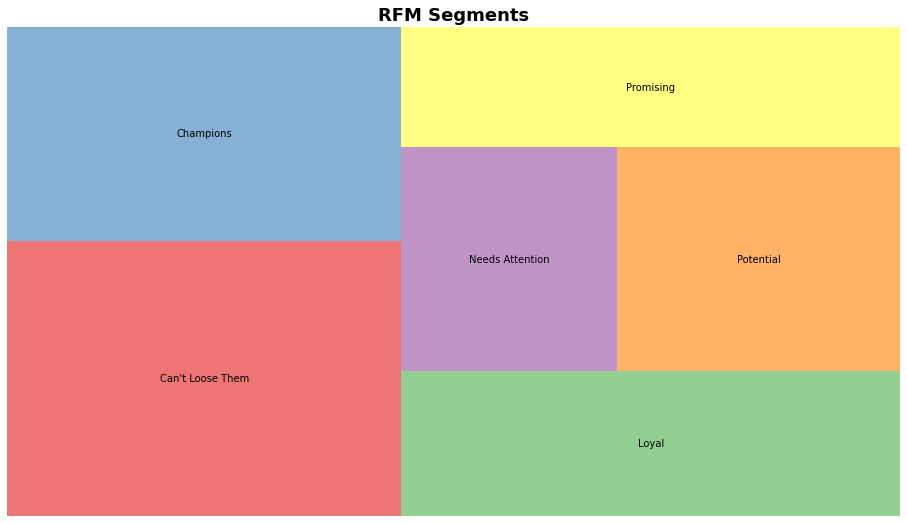

In [25]:
import squarify
import matplotlib.pyplot as plt

rfm_level_agg.columns = ['RMean','FMean','MMean', "Tmean", 'Count']

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'],
              color=sns.color_palette("Set1", n_colors=7),
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

### Clustering

In [11]:
datamart_rfm.head()

,Recency,Frequency,Monetary,Tenure,R,F,M,T,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,,,
12346.0,326,2,0.00,326,1,1,1,3,1113,6,Promising
12347.0,2,182,4310.00,367,4,4,4,4,4444,16,Can't Loose Them
12348.0,75,31,1797.24,358,2,2,4,4,2244,12,Champions
12349.0,19,73,1757.55,19,3,3,4,1,3341,11,Loyal
12350.0,310,17,334.40,310,1,1,2,3,1123,7,Promising


In [26]:
from pycaret.clustering import *

setup = setup(data = datamart_rfm,
            numeric_features= ["R", "F", "M", "T"],
            ignore_features=["Recency", "Frequency", "Monetary", "Tenure", "RFM_Segment", "RFM_Score", "RFM_Level"],
            normalize = True,
            silent=True,
            verbose=False
            )

In [27]:
#Creamos un modelo de clustering con N clusters segun lo visto en el metodo de elbow
kmeans = create_model("kmeans", algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1898, tol=0.0001, verbose=True)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3175,2632.3883,1.1812,0,0,0


#### Plot models

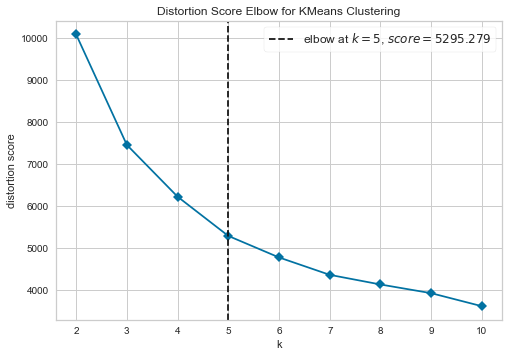

In [28]:
#Revisamos elbow score para ver cuantos clusters necesitamos
plot_model(kmeans, plot="elbow")

In [29]:
#Revisamos elbow score para ver cuantos clusters necesitamos
plot_model(kmeans, plot="cluster")

In [16]:
#Vemos cuantos hay por cada segmento
plot_model(kmeans, plot="distribution")

#### Predict

In [32]:
datamart_rfm = predict_model(kmeans, data = datamart_rfm)
datamart_rfm.head()

,Recency,Frequency,Monetary,Tenure,R,F,M,T,RFM_Segment,RFM_Score,RFM_Level,Cluster
CustomerID,,,,,,,,,,,,
12346.0,326,2,0.00,326,1,1,1,3,1113,6,Promising,Cluster 1
12347.0,2,182,4310.00,367,4,4,4,4,4444,16,Can't Loose Them,Cluster 2
12348.0,75,31,1797.24,358,2,2,4,4,2244,12,Champions,Cluster 2
12349.0,19,73,1757.55,19,3,3,4,1,3341,11,Loyal,Cluster 0
12350.0,310,17,334.40,310,1,1,2,3,1123,7,Promising,Cluster 1


In [33]:
datamart_melt = pd.melt(datamart_rfm.reset_index(),
id_vars=['CustomerID', 'Cluster'],
value_vars=['R', 'F', 'M', 'T'],
var_name='Attribute',
value_name='Value')

datamart_melt.head()

,CustomerID,Cluster,Attribute,Value
0,12346.0,Cluster 1,R,1
1,12347.0,Cluster 2,R,4
2,12348.0,Cluster 2,R,2
3,12349.0,Cluster 0,R,3
4,12350.0,Cluster 1,R,1


<AxesSubplot:title={'center':'RFM Snake plot'}, xlabel='Attribute', ylabel='Value'>

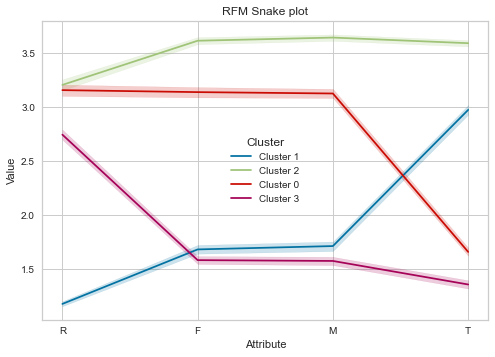

In [35]:
plt.title('RFM Snake plot')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)

### Saving dataset

In [23]:
datamart_rfm.to_csv('../DB/Customers.csv')

In [21]:
output = df.merge(datamart_rfm.reset_index(), on='CustomerID')
output.to_csv('../DB/Output.csv')
output.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,Recency,...,Monetary,Tenure,R,F,M,T,RFM_Segment,RFM_Score,RFM_Level,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,302,...,5288.63,374,1,4,4,4,1444,13,Champions,Cluster 2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,302,...,5288.63,374,1,4,4,4,1444,13,Champions,Cluster 2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,302,...,5288.63,374,1,4,4,4,1444,13,Champions,Cluster 2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,302,...,5288.63,374,1,4,4,4,1444,13,Champions,Cluster 2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,302,...,5288.63,374,1,4,4,4,1444,13,Champions,Cluster 2
